# Task 1: Define Problem

**Overview**:
* Bộ dữ liệu GoldUP.csv bao gồm các chỉ số kinh tế như giá vàng, giá dầu thô, lãi suất, tỷ giá hối đoái, chỉ số thị trường chứng khoán (Sensex), chỉ số giá tiêu dùng (CPI) và chỉ số USD theo thời gian.
* Hiểu được cách các chỉ số kinh tế này ảnh hưởng đến giá vàng có thể giúp các nhà đầu tư đưa ra quyết định sáng suốt.

# Task 2: Prepare and Clean Data

## Import library

In [202]:
# Install necessary packages 
# install.packages(c("tidyverse"))
library(readr)
library(lubridate)
library(tidyverse)
library(ggplot2)
library(reshape2)
library(dplyr)
library(randomForest)
library(caret)

## Load in dataset

In [203]:
# Load the dataset
gold_data <- read_csv("/kaggle/input/r-lab3/GoldUP.csv")

# Preview the data
head(gold_data)

Rows: 239 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Date
dbl (7): Gold_Price, Crude_Oil, Interest_Rate, USD_INR, Sensex, CPI, USD_Index

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01-10-2000,4538,1455.51,8.0,46.31830,3711.02,37.23,116.65
01-11-2000,4483,1512.47,8.0,46.78361,3997.99,37.31,115.24
01-12-2000,4541,1178.11,8.0,46.74586,3972.12,36.98,109.56
01-01-2001,4466,1208.18,8.0,46.53603,4326.72,36.90,110.52
01-02-2001,4370,1267.18,7.5,46.51459,4247.04,36.73,112.01
01-03-2001,4269,1166.45,7.0,46.60935,3604.38,36.90,117.37


## Data preprocessing and overview

In [204]:
#change Date column data type to cols_date()
gold_data <- gold_data %>%
  mutate(Date = dmy(Date)) 
# str(gold_data)

In [205]:
head(gold_data)

Date,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000-10-01,4538,1455.51,8.0,46.31830,3711.02,37.23,116.65
2000-11-01,4483,1512.47,8.0,46.78361,3997.99,37.31,115.24
2000-12-01,4541,1178.11,8.0,46.74586,3972.12,36.98,109.56
2001-01-01,4466,1208.18,8.0,46.53603,4326.72,36.90,110.52
2001-02-01,4370,1267.18,7.5,46.51459,4247.04,36.73,112.01
2001-03-01,4269,1166.45,7.0,46.60935,3604.38,36.90,117.37


* **Date**: Ngày tương ứng với dữ liệu kinh tế được ghi lại.
* **Crude_Oil**: Giá dầu thô, có thể tác động đến giá vàng do ảnh hưởng của nó đến lạm phát và hoạt động kinh tế.
* **Interest_Rate**: Lãi suất hiện hành, thường do ngân hàng trung ương của một quốc gia đặt ra. Lãi suất cao hơn có thể dẫn đến giá vàng thấp hơn vì các nhà đầu tư tìm kiếm lợi nhuận cao hơn từ các tài sản có lãi.
* **USD_INR**: Tỷ giá hối đoái giữa Đô la Mỹ và Rupee Ấn Độ. Đồng đô la mạnh hơn có thể ảnh hưởng tiêu cực đến giá vàng.
* **Sensex**: Chỉ số nhạy cảm của Sở giao dịch chứng khoán Bombay, chỉ ra hiệu suất của thị trường chứng khoán tại Ấn Độ. Hiệu suất thị trường chứng khoán cao hơn có thể dẫn đến nhu cầu vàng thấp hơn vì các nhà đầu tư thích cổ phiếu hơn.
* **CPI**: Chỉ số giá tiêu dùng, thước đo lạm phát. CPI cao hơn cho thấy lạm phát cao hơn, có thể làm tăng giá vàng vì vàng thường được coi là hàng rào chống lại lạm phát.
* **USD_Index**: Thước đo giá trị của đồng đô la Mỹ so với một rổ các loại tiền tệ nước ngoài. Đồng đô la mạnh hơn có thể dẫn đến giá vàng thấp hơn.
-**Gold_Price (Target value)**: Giá vàng theo đơn vị (thường là theo ounce) theo loại tiền tệ cụ thể.

#### Bộ dữ liệu chủ yếu sử dụng các đơn vị sau cho các tính năng của nó:

* **Giá vàng**: Có thể tính bằng Rupee Ấn Độ (INR) cho một ounce.
* **Dầu thô**: Thường tính bằng USD cho một thùng.
* **Lãi suất**: Phần trăm (%).
* **USD_INR**: Tỷ giá hối đoái (số Rupee Ấn Độ trên một Đô la Mỹ).
* **Sensex**: Giá trị chỉ số (không có đơn vị cụ thể).
* **CPI**: Giá trị chỉ số (không có đơn vị cụ thể, nhưng nó thể hiện sự thay đổi giá tiêu dùng).
* **USD_Index**: Giá trị chỉ số (không có đơn vị cụ thể, phản ánh sức mạnh của đồng đô la Mỹ so với một nhóm tiền tệ).

**USD_index calculation:**
* Euro (EUR): 57.6 percent
* Japanese Yen (JPY): 13.6 percent
* British Pound (GBP): 11.9 percent 
* Canadian Dollar (CAD): 9.1 percent
* Swedish Krona (SEK): 4.2 percent 
* Swiss Franc (CHF): 3.6 percent

In [206]:
# Get summary statistics for the data
summary(gold_data)

# Check for missing values
sum(is.na(gold_data))

      Date              Gold_Price      Crude_Oil      Interest_Rate   
 Min.   :2000-10-01   Min.   : 4267   Min.   : 887.4   Min.   : 4.250  
 1st Qu.:2005-09-16   1st Qu.: 6712   1st Qu.:2180.7   1st Qu.: 6.000  
 Median :2010-09-01   Median :19056   Median :3303.6   Median : 6.000  
 Mean   :2010-08-31   Mean   :19299   Mean   :3397.7   Mean   : 6.716  
 3rd Qu.:2015-08-16   3rd Qu.:29364   3rd Qu.:4492.9   3rd Qu.: 7.000  
 Max.   :2020-08-01   Max.   :52917   Max.   :6926.8   Max.   :10.250  
    USD_INR          Sensex           CPI           USD_Index     
 Min.   :39.37   Min.   : 2812   Min.   : 36.73   Min.   : 71.80  
 1st Qu.:45.47   1st Qu.: 8263   1st Qu.: 45.19   1st Qu.: 81.11  
 Median :48.66   Median :17465   Median : 68.47   Median : 88.94  
 Mean   :53.80   Mean   :18172   Mean   : 73.37   Mean   : 90.18  
 3rd Qu.:63.86   3rd Qu.:26662   3rd Qu.:101.37   3rd Qu.: 97.16  
 Max.   :76.22   Max.   :41254   Max.   :129.30   Max.   :120.24  

[1] 0

> **No missing value**

In [207]:
# Example of binning the gold prices
gold_data_binned <- gold_data
gold_data_binned$Gold_Binned <- cut(gold_data_binned$Gold_Price, breaks = 5)

In [208]:
summary(gold_data_binned)

      Date              Gold_Price      Crude_Oil      Interest_Rate   
 Min.   :2000-10-01   Min.   : 4267   Min.   : 887.4   Min.   : 4.250  
 1st Qu.:2005-09-16   1st Qu.: 6712   1st Qu.:2180.7   1st Qu.: 6.000  
 Median :2010-09-01   Median :19056   Median :3303.6   Median : 6.000  
 Mean   :2010-08-31   Mean   :19299   Mean   :3397.7   Mean   : 6.716  
 3rd Qu.:2015-08-16   3rd Qu.:29364   3rd Qu.:4492.9   3rd Qu.: 7.000  
 Max.   :2020-08-01   Max.   :52917   Max.   :6926.8   Max.   :10.250  
    USD_INR          Sensex           CPI           USD_Index     
 Min.   :39.37   Min.   : 2812   Min.   : 36.73   Min.   : 71.80  
 1st Qu.:45.47   1st Qu.: 8263   1st Qu.: 45.19   1st Qu.: 81.11  
 Median :48.66   Median :17465   Median : 68.47   Median : 88.94  
 Mean   :53.80   Mean   :18172   Mean   : 73.37   Mean   : 90.18  
 3rd Qu.:63.86   3rd Qu.:26662   3rd Qu.:101.37   3rd Qu.: 97.16  
 Max.   :76.22   Max.   :41254   Max.   :129.30   Max.   :120.24  
              Gold_Binned 


# Task 3: Conduct Exploratory Data Analysis

In [209]:
str(gold_data)

tibble [239 × 8] (S3: tbl_df/tbl/data.frame)
 $ Date         : Date[1:239], format: "2000-10-01" "2000-11-01" ...
 $ Gold_Price   : num [1:239] 4538 4483 4541 4466 4370 ...
 $ Crude_Oil    : num [1:239] 1456 1512 1178 1208 1267 ...
 $ Interest_Rate: num [1:239] 8 8 8 8 7.5 7 7 7 7 7 ...
 $ USD_INR      : num [1:239] 46.3 46.8 46.7 46.5 46.5 ...
 $ Sensex       : num [1:239] 3711 3998 3972 4327 4247 ...
 $ CPI          : num [1:239] 37.2 37.3 37 36.9 36.7 ...
 $ USD_Index    : num [1:239] 117 115 110 111 112 ...


In [210]:
# Descriptive statistics
data_summary <- gold_data %>%
  summarize(across(everything(), list(mean = mean, sd = sd, min = min, max = max)))

In [211]:
str(data_summary)

tibble [1 × 32] (S3: tbl_df/tbl/data.frame)
 $ Date_mean         : Date[1:1], format: "2010-08-31"
 $ Date_sd           : num 2104
 $ Date_min          : Date[1:1], format: "2000-10-01"
 $ Date_max          : Date[1:1], format: "2020-08-01"
 $ Gold_Price_mean   : num 19299
 $ Gold_Price_sd     : num 11669
 $ Gold_Price_min    : num 4267
 $ Gold_Price_max    : num 52917
 $ Crude_Oil_mean    : num 3398
 $ Crude_Oil_sd      : num 1552
 $ Crude_Oil_min     : num 887
 $ Crude_Oil_max     : num 6927
 $ Interest_Rate_mean: num 6.72
 $ Interest_Rate_sd  : num 1.19
 $ Interest_Rate_min : num 4.25
 $ Interest_Rate_max : num 10.2
 $ USD_INR_mean      : num 53.8
 $ USD_INR_sd        : num 10.3
 $ USD_INR_min       : num 39.4
 $ USD_INR_max       : num 76.2
 $ Sensex_mean       : num 18172
 $ Sensex_sd         : num 11032
 $ Sensex_min        : num 2812
 $ Sensex_max        : num 41254
 $ CPI_mean          : num 73.4
 $ CPI_sd            : num 29.1
 $ CPI_min           : num 36.7
 $ CPI_max        

,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
Gold_Price,1.0000000,0.6616897,0.24199570,0.8555548,0.89749037,0.959048215,-0.132789075
Crude_Oil,0.6616897,1.0000000,0.48456717,0.3481417,0.57050615,0.565025318,-0.589053606
Interest_Rate,0.2419957,0.4845672,1.00000000,0.2224741,0.08623231,0.199081954,-0.025687614
USD_INR,0.8555548,0.3481417,0.22247411,1.0000000,0.83807502,0.928814544,0.290248080
Sensex,0.8974904,0.5705062,0.08623231,0.8380750,1.00000000,0.960334198,-0.092004080
CPI,0.9590482,0.5650253,0.19908195,0.9288145,0.96033420,1.000000000,-0.007089212
USD_Index,-0.1327891,-0.5890536,-0.02568761,0.2902481,-0.09200408,-0.007089212,1.000000000


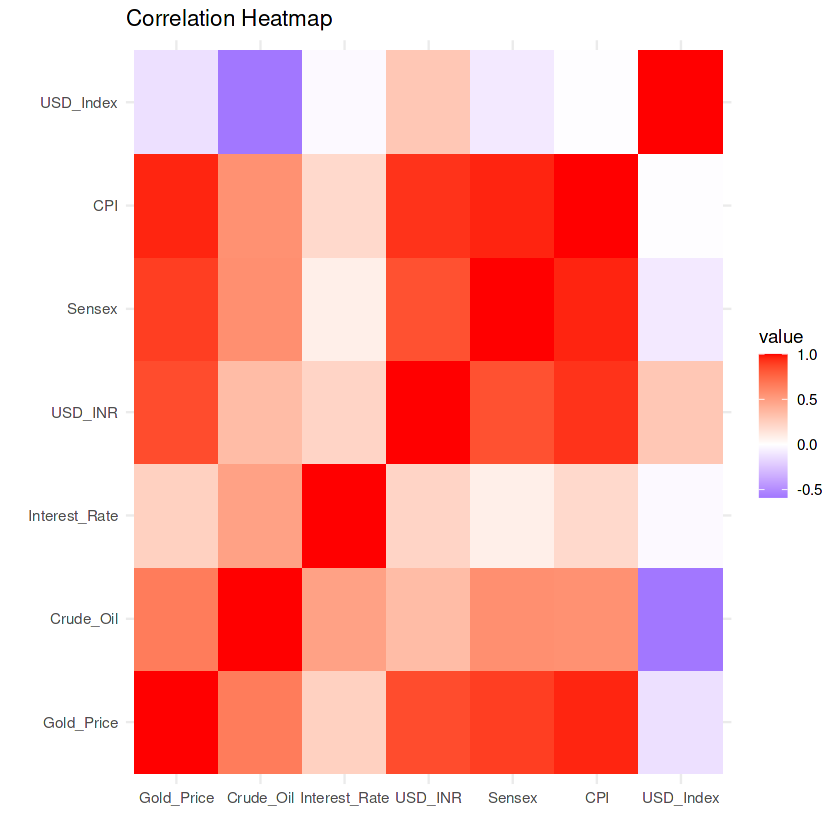

In [212]:
# Calculate correlation matrix for numeric columns
correlation_matrix <- cor(select_if(gold_data, is.numeric), use = "complete.obs")

# Display the correlation matrix
correlation_matrix

# Visualize the correlation matrix with a heatmap
ggplot(melt(correlation_matrix), aes(Var1, Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0) +
  theme_minimal() +
  labs(title = "Correlation Heatmap", x = "", y = "")


Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”
Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”


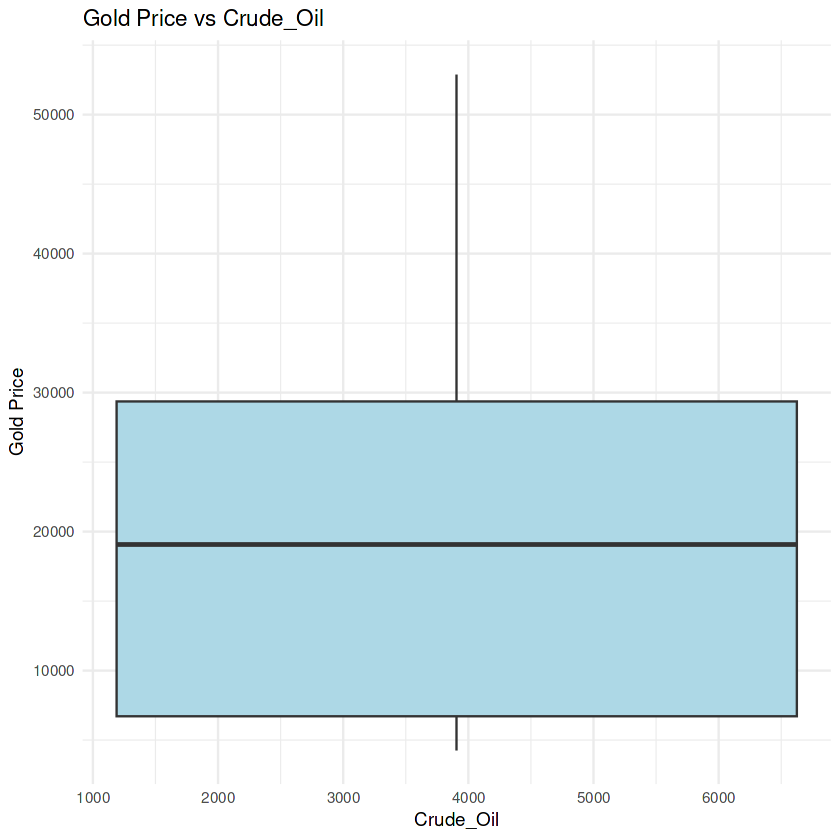

Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”


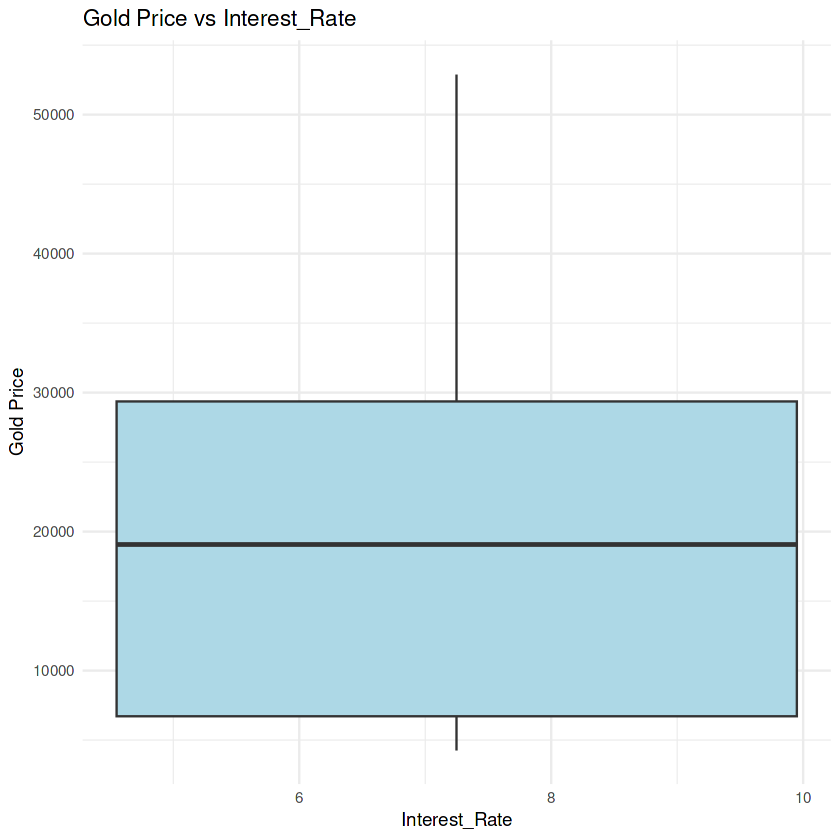

Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”


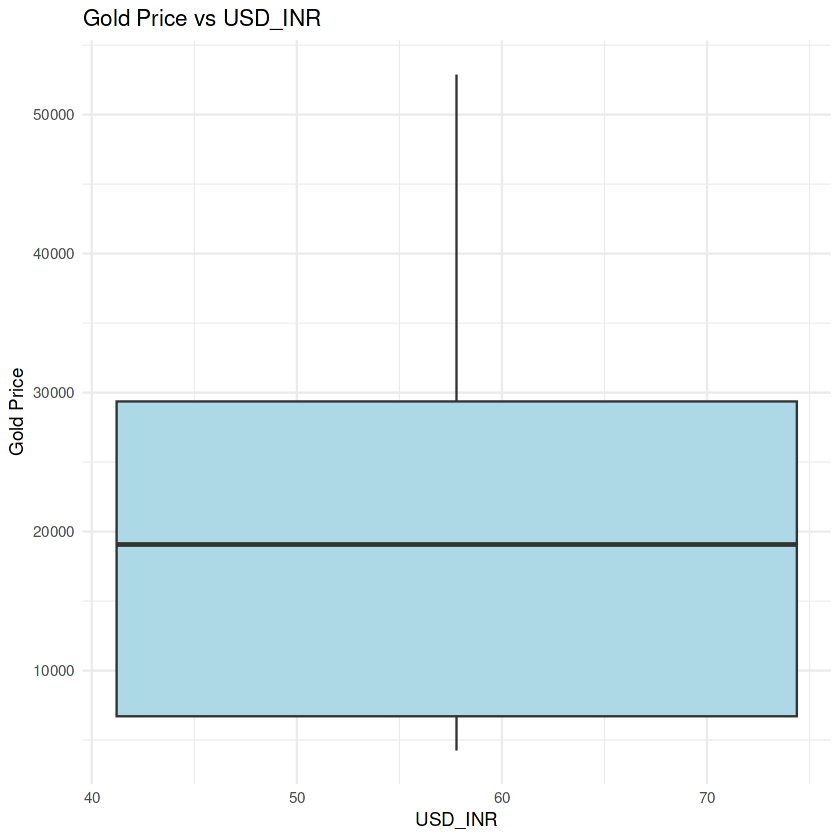

Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”


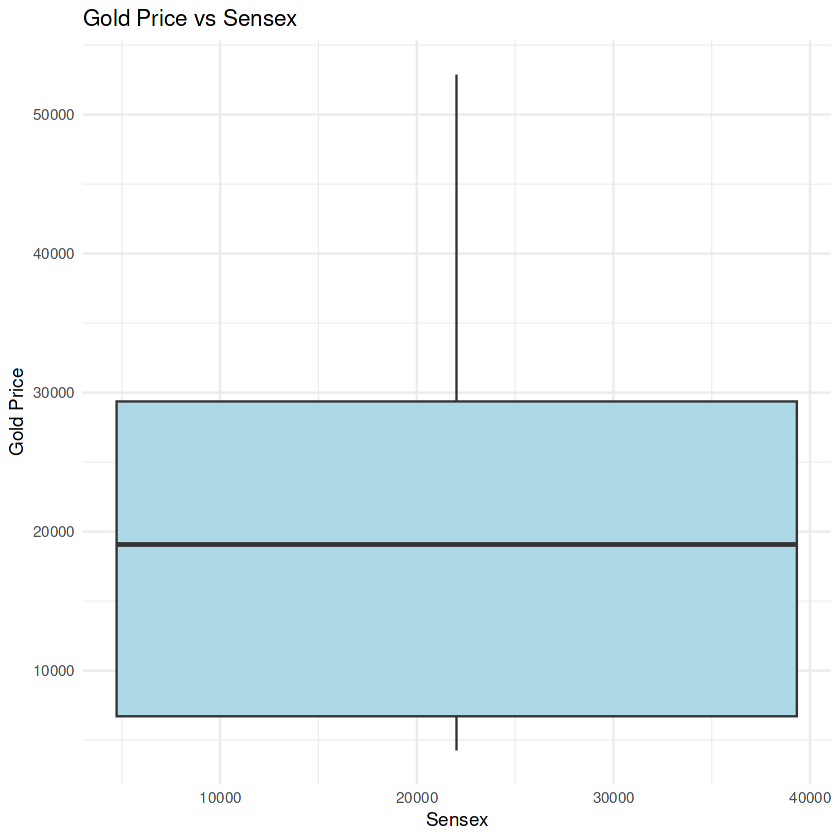

Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”


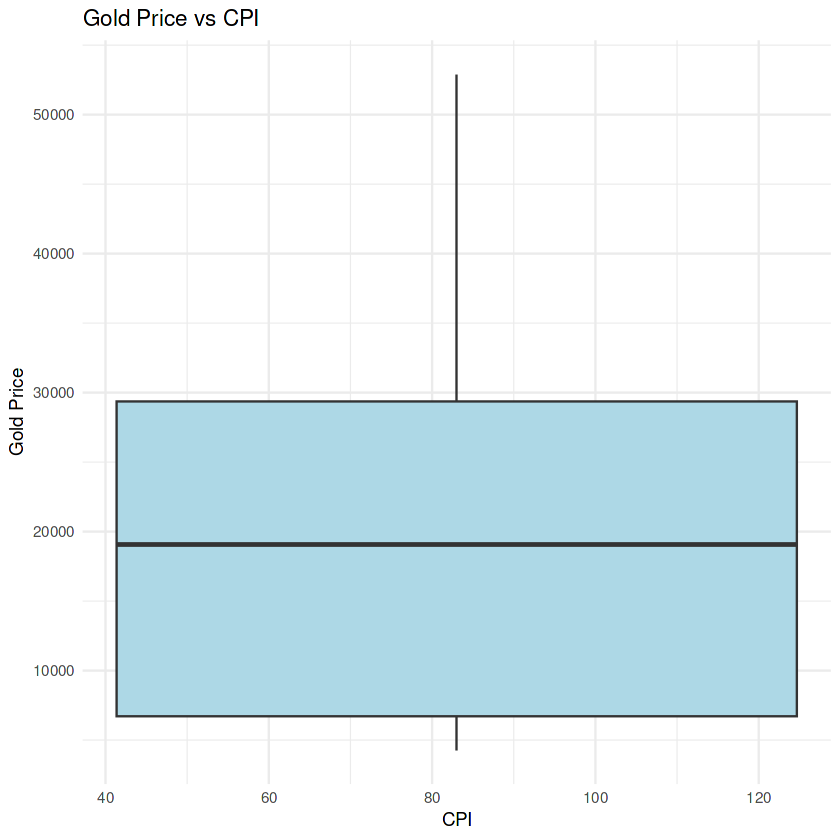

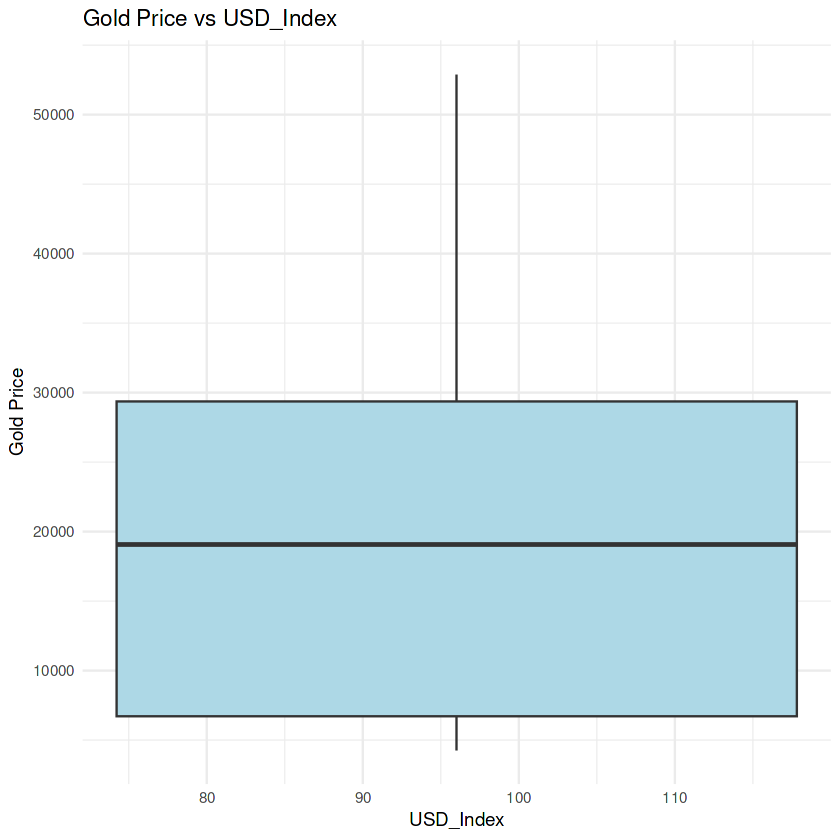

In [213]:
# Boxplots for all numeric features vs Gold_Price
numeric_columns <- gold_data %>%
  select_if(is.numeric) %>%
  names()

for (col in numeric_columns) {
  if (col != "Gold_Price") {
    print(
      ggplot(gold_data, aes_string(x = col, y = "Gold_Price")) +
        geom_boxplot(fill = "lightblue") +
        theme_minimal() +
        labs(title = paste("Gold Price vs", col), x = col, y = "Gold Price")
    )
  }
}


In [214]:
# Pearson correlation for numeric features with Gold_Price
for (col in numeric_columns) {
  if (col != "Gold_Price") {
    # Pearson correlation test
    corr_test <- cor.test(gold_data[[col]], gold_data$Gold_Price)
    
    # Extract correlation and P-value
    correlation <- corr_test$estimate
    p_value <- corr_test$p.value
    
    # Print correlation and P-value
    print(paste("Correlation between Gold_Price and", col, ":", correlation))
    print(paste("P-value for correlation between Gold_Price and", col, ":", p_value))
  }
}


[1] "Correlation between Gold_Price and Crude_Oil : 0.661689666364671"
[1] "P-value for correlation between Gold_Price and Crude_Oil : 1.77899467239512e-31"
[1] "Correlation between Gold_Price and Interest_Rate : 0.241995696994065"
[1] "P-value for correlation between Gold_Price and Interest_Rate : 0.000158185835089992"
[1] "Correlation between Gold_Price and USD_INR : 0.855554814806306"
[1] "P-value for correlation between Gold_Price and USD_INR : 1.0475018021237e-69"
[1] "Correlation between Gold_Price and Sensex : 0.897490374463837"
[1] "P-value for correlation between Gold_Price and Sensex : 3.16614897235858e-86"
[1] "Correlation between Gold_Price and CPI : 0.959048215445856"
[1] "P-value for correlation between Gold_Price and CPI : 7.83045199367061e-132"
[1] "Correlation between Gold_Price and USD_Index : -0.132789074792995"
[1] "P-value for correlation between Gold_Price and USD_Index : 0.0402475824582412"


**1. **Giá vàng so với Dầu thô****
* Tương quan: 0,6617 (Thuận)
* Giá trị P: 1,78e-31
* Diễn giải: Có một tương quan thuận khá mạnh giữa Giá vàng và Dầu thô. Điều này có nghĩa là khi giá dầu thô tăng, giá vàng cũng có xu hướng tăng theo. Giá trị P cực kỳ nhỏ (thấp hơn nhiều so với 0,05), cho thấy mối tương quan này có ý nghĩa thống kê.

**2. **Giá vàng so với Lãi suất****
* Tương quan: 0,2420 (Thuận)
* Giá trị P: 0,00016
* Diễn giải: Mối tương quan giữa Giá vàng và Lãi suất là thuận (nhưng yếu). Điều này cho thấy rằng mặc dù có một số mối quan hệ giữa giá vàng và lãi suất, nhưng mối quan hệ này không quá mạnh. Tuy nhiên, giá trị P thấp hơn 0,05, điều này có nghĩa là mối tương quan yếu này vẫn có ý nghĩa thống kê.

**3. **Gold_Price so với USD_INR****
* Tương quan: 0,8556 (Thuận)
* Giá trị P: 1,05e-69
* Diễn giải: Có một tương quan thuận mạnh giữa Gold_Price và tỷ giá hối đoái USD/INR. Điều này cho thấy khi đồng rupee Ấn Độ suy yếu so với đồng đô la Mỹ (tức là USD/INR tăng), giá vàng theo INR cũng tăng. Giá trị P cực kỳ nhỏ xác nhận rằng mối tương quan này có ý nghĩa rất lớn.

**4. **Gold_Price so với Sensex****
* Tương quan: 0,8975 (Thuận)
* Giá trị P: 3,17e-86
* Diễn giải: Có một tương quan thuận rất lớn giữa Gold_Price và Sensex (chỉ số thị trường chứng khoán). Điều này cho thấy giá vàng có xu hướng biến động theo cùng hướng với chỉ số thị trường chứng khoán trong tập dữ liệu này. Giá trị P nhỏ khiến mối quan hệ này có ý nghĩa rất lớn.

**5. Gold_Price so với CPI (Chỉ số giá tiêu dùng)**
* Tương quan: 0,9590 (Thuận)
* Giá trị P: 7,83e-132
* Diễn giải: Tương quan giữa Gold_Price và CPI cực kỳ mạnh. Điều này cho thấy giá vàng tăng gần như song song với lạm phát (được đo bằng CPI). Giá trị P gần như bằng 0, cho thấy mối quan hệ cực kỳ mạnh và đáng kể giữa giá vàng và lạm phát.

**6. Gold_Price so với USD_Index**
* Tương quan: -0,1328 (Nghịch)
* Giá trị P: 0,0402
* Diễn giải: Có tương quan nghịch yếu giữa Gold_Price và Chỉ số USD. Điều này cho thấy khi giá trị của đồng đô la Mỹ tăng so với một rổ các loại tiền tệ khác (được đo bằng Chỉ số USD), giá vàng có xu hướng giảm nhẹ. Giá trị P chỉ dưới 0,05 một chút, nghĩa là tương quan âm yếu này có ý nghĩa thống kê, mặc dù không quá mạnh.
> => CPI và Sensex có mối tương quan mạnh nhất với Gold_Price, cho thấy lạm phát và biến động thị trường chứng khoán có thể là những yếu tố dự báo quan trọng về giá vàng. Trong khi đó, USD_INR cũng cho thấy mối liên hệ chặt chẽ, có thể là do đồng Rupee Ấn Độ yếu hơn khiến vàng đắt hơn theo giá INR. Ngược lại, Chỉ số USD có tác động tiêu cực nhẹ, nhưng ảnh hưởng của nó tương đối nhỏ so với các yếu tố khác.

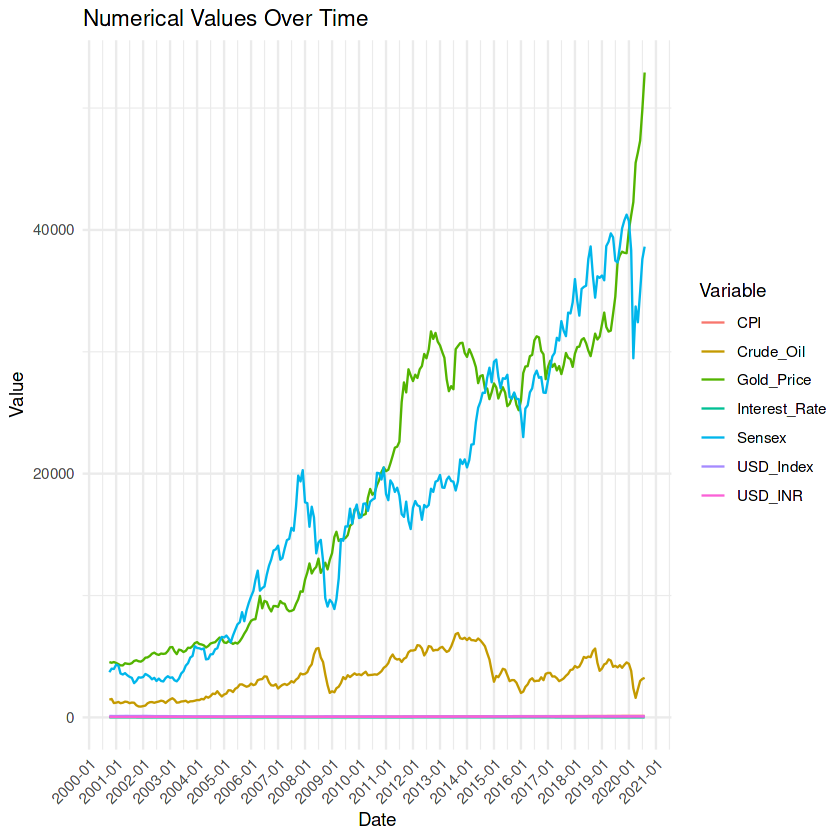

In [215]:
# Reshape the data to long format
long_data <- gold_data %>%
  pivot_longer(cols = -Date, names_to = "Variable", values_to = "Value")
# Create the plot
ggplot(data = long_data, aes(x = Date, y = Value, color = Variable)) +
  geom_line() +  # Line plot for each variable
  labs(title = "Numerical Values Over Time",
       x = "Date",
       y = "Value") +
  theme_minimal() +  # Minimal theme for better aesthetics
  scale_x_date(date_labels = "%Y-%m", date_breaks = "1 year") +  # Format x-axis
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability

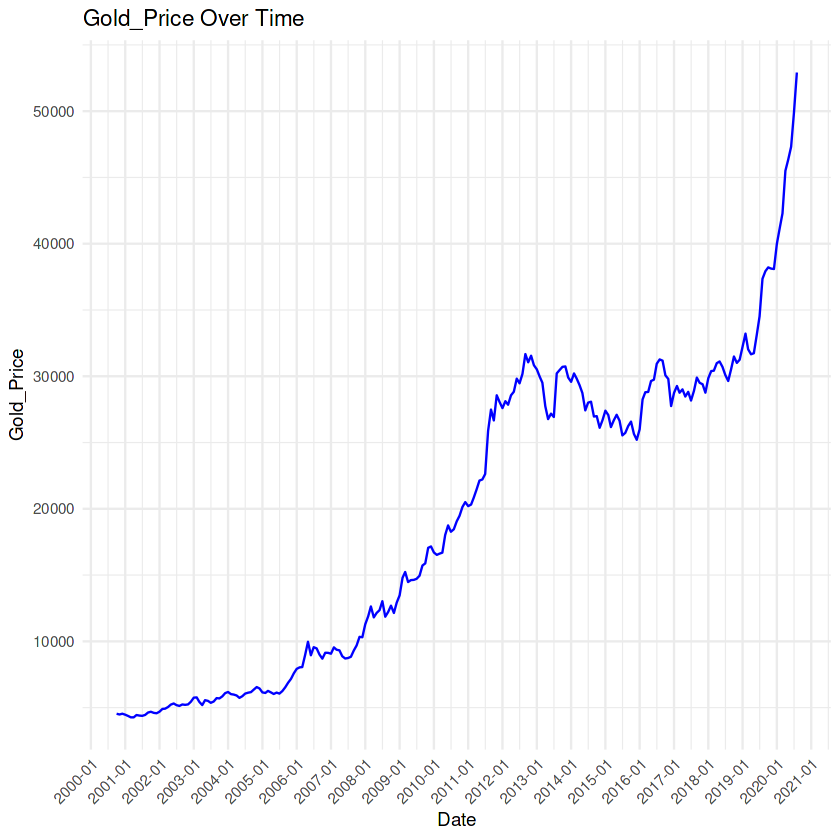

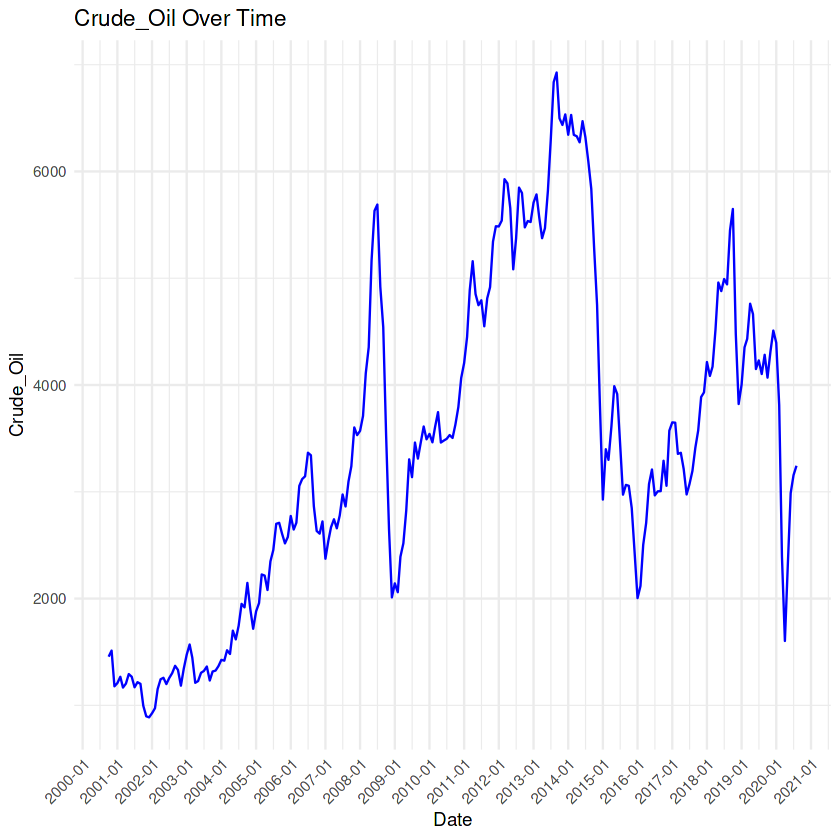

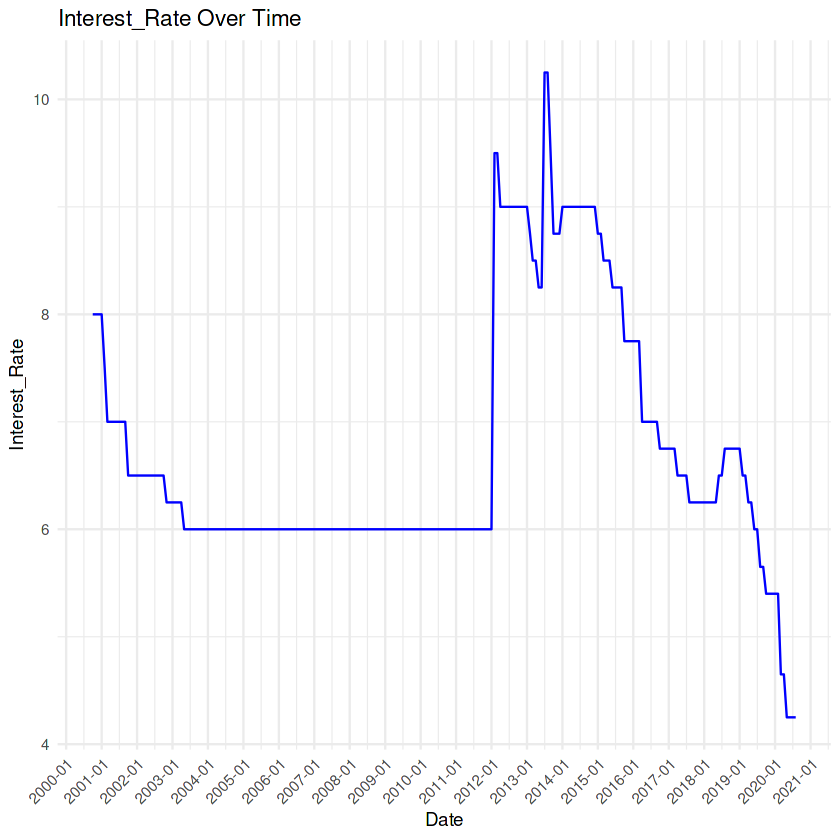

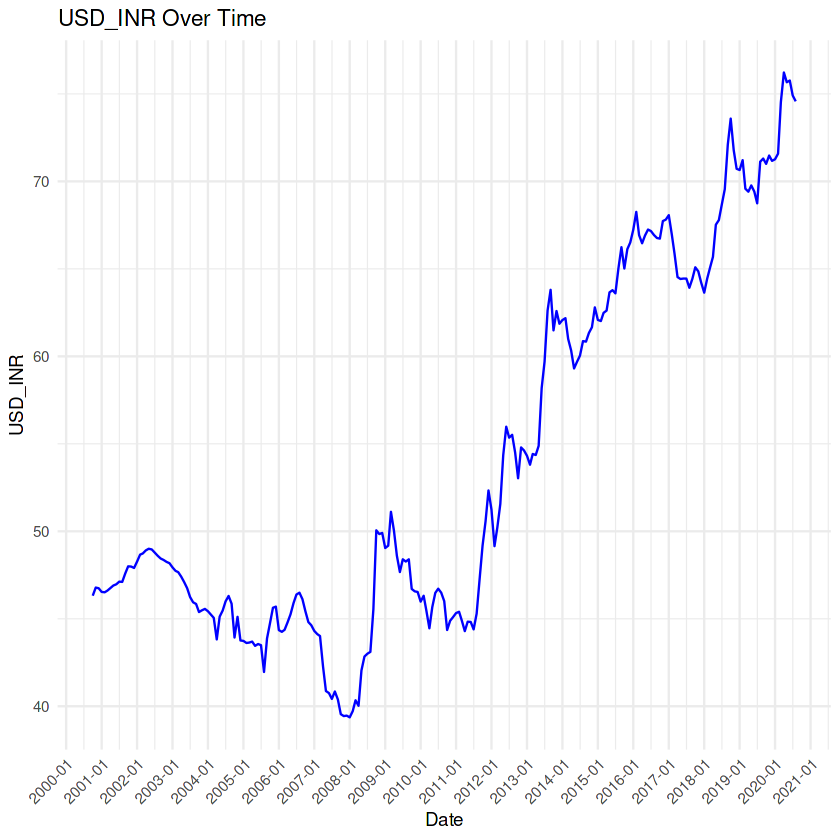

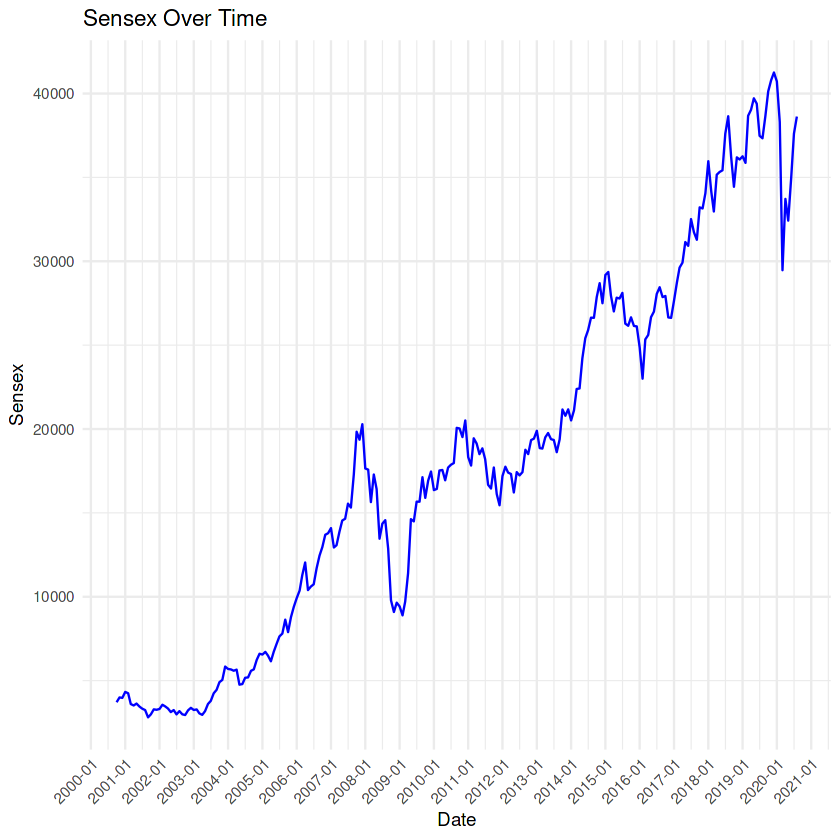

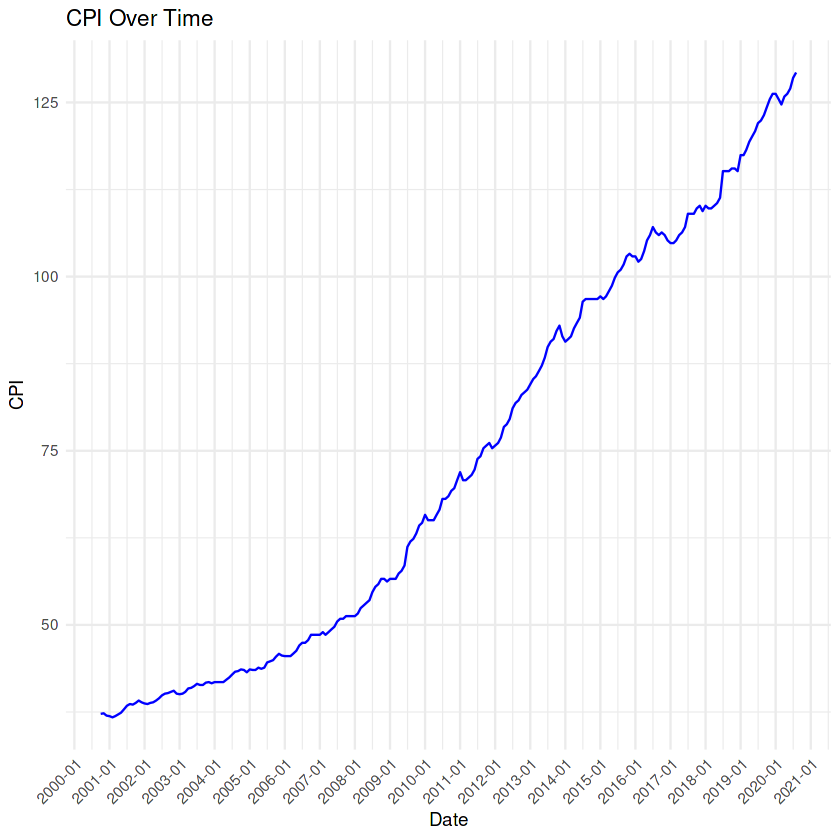

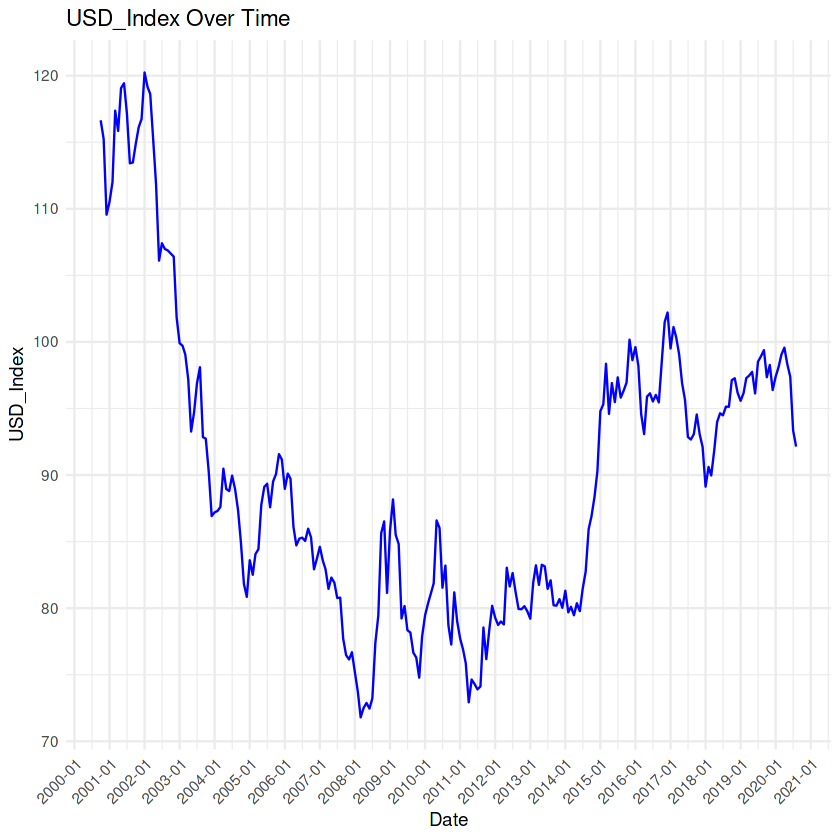

In [216]:
# Get the names of numeric columns
numeric_columns <- names(gold_data)[sapply(gold_data, is.numeric)]

# Loop through each numeric variable and create a plot
for (var in numeric_columns) {
  p <- ggplot(gold_data, aes_string(x = "Date", y = var)) +
    geom_line(color = "blue") +  # You can customize colors
    labs(title = paste(var, "Over Time"),
         x = "Date",
         y = var) +
    theme_minimal() +
    scale_x_date(date_labels = "%Y-%m", date_breaks = "1 year") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  print(p)  # Print the plot
}

# Task 5: Build and Evaluate Model


In [217]:
set.seed(123)

In [218]:
# Normalize numeric features if necessary
gold_data <- gold_data %>%
  mutate(across(where(is.numeric), scale))

In [219]:
head(gold_data)

Date,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
<date>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
2000-10-01,-1.264990,-1.251703,1.0806116,-0.7260613,-1.310837,-1.241733,2.339645
2000-11-01,-1.269704,-1.214993,1.0806116,-0.6809338,-1.284825,-1.238984,2.215006
2000-12-01,-1.264733,-1.430483,1.0806116,-0.6845956,-1.287170,-1.250322,1.712911
2001-01-01,-1.271161,-1.411103,1.0806116,-0.7049447,-1.255028,-1.253071,1.797772
2001-02-01,-1.279388,-1.373079,0.6598456,-0.7070238,-1.262250,-1.258911,1.929484
2001-03-01,-1.288043,-1.437997,0.2390796,-0.6978339,-1.320503,-1.253071,2.403291


In [220]:
gold_data <- gold_data %>% select(-Date)
gold_data <- gold_data %>% select(-USD_Index, -Interest_Rate)

In [221]:
set.seed(123)  # For reproducibility
train_index <- createDataPartition(gold_data$Gold_Price, p = 0.8, list = FALSE)
train_data <- gold_data[train_index, ]
test_data <- gold_data[-train_index, ]

In [256]:
rf_model <- randomForest(Gold_Price ~ ., 
                         data = train_data, 
                         importance = TRUE, 
                         ntree = 500,
                         splitrule = "variance",
                         mtry = 4,
                         min.node.size = 5)

# View model summary
print(rf_model)


Call:
 randomForest(formula = Gold_Price ~ ., data = train_data, importance = TRUE,      ntree = 500, splitrule = "variance", mtry = 4, min.node.size = 5) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 0.01017511
                    % Var explained: 98.98


In [257]:
# Make predictions
predictions <- predict(rf_model, newdata = test_data)

# Evaluate performance
results <- data.frame(Actual = test_data$Gold_Price, Predicted = predictions)
print(head(results))

# Calculate RMSE
rmse <- sqrt(mean((results$Actual - results$Predicted)^2))
cat("Root Mean Squared Error (RMSE):", rmse, "\n")

     Actual Predicted
1 -1.271161 -1.276536
2 -1.272617 -1.266741
3 -1.251707 -1.255879
4 -1.232254 -1.231321
5 -1.209287 -1.206294
6 -1.194290 -1.174073
Root Mean Squared Error (RMSE): 0.06417283 


,%IncMSE,IncNodePurity
Crude_Oil,17.70580,0.9095305
USD_INR,15.49415,2.8733562
Sensex,27.95127,1.4336157
CPI,127.77327,185.3408382


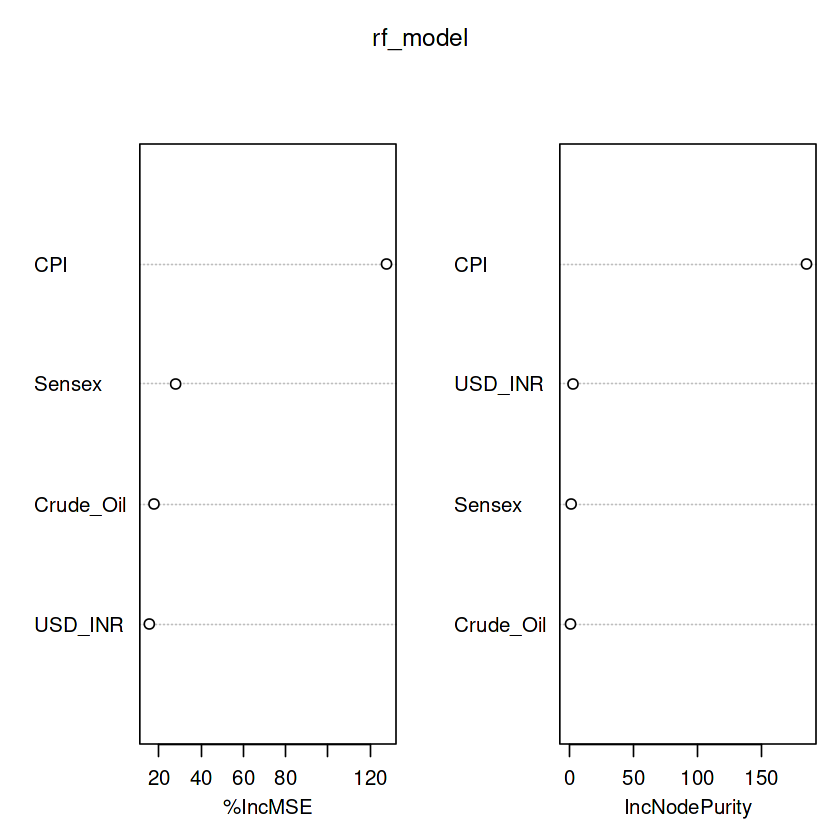

In [258]:
importance(rf_model)
varImpPlot(rf_model)

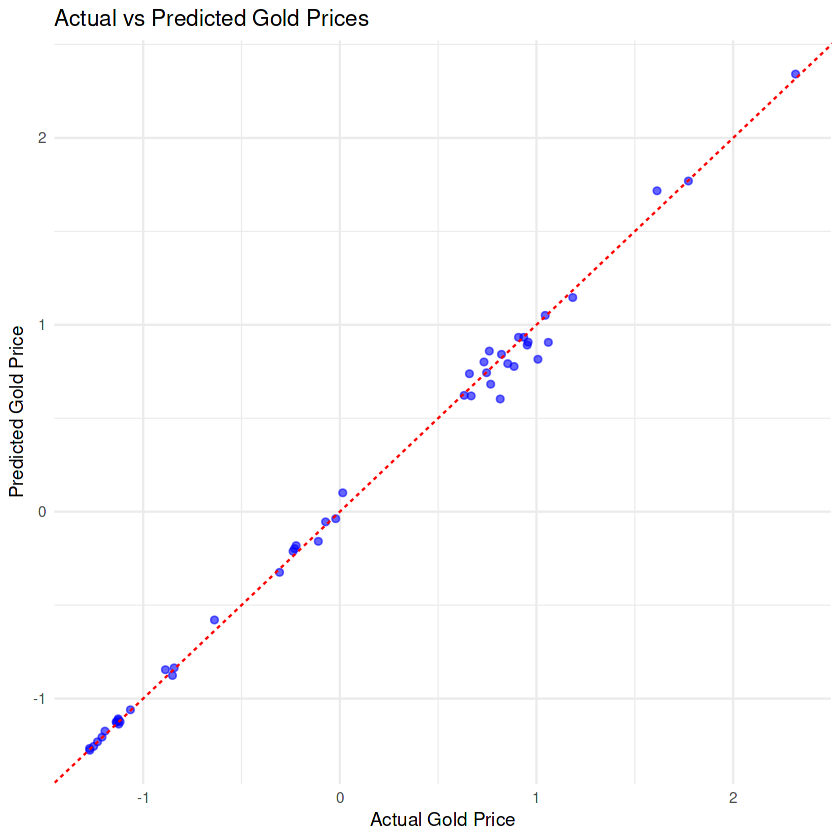

In [259]:
predictions <- predict(rf_model, newdata = test_data)

# Create a data frame for actual vs predicted values
results <- data.frame(Actual = test_data$Gold_Price, Predicted = predictions)

# Plot Actual vs Predicted
ggplot(results, aes(x = Actual, y = Predicted)) +
  geom_point(color = "blue", alpha = 0.6) +  # Scatter plot
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +  # 45-degree line
  labs(title = "Actual vs Predicted Gold Prices",
       x = "Actual Gold Price",
       y = "Predicted Gold Price") +
  theme_minimal() +
  xlim(min(results$Actual), max(results$Actual)) +  # Set x limits
  ylim(min(results$Predicted), max(results$Predicted))  # Set y limits